#  Instacart Market Basket Analysis

## 라이브러리 호출

In [1]:
import warnings
warnings.filterwarnings("ignore")
import xgboost
import lightgbm
import missingno
import sklearn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# seaborn 기본 설정
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='NanumBarunGothic',
              rc=custom_params)

## 데이터 로드 및 확인

In [4]:
# 데이터 호출하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data2'
# data_dir = os.getenv('HOME')+'/aiffel/workplace/project/project_5'

aisles_data_path = join(data_dir, 'aisles.csv')
departments_data_path = join(data_dir, 'departments.csv') 
order_products__prior_data_path = join(data_dir, 'order_products__prior.csv') 
order_products__train_data_path = join(data_dir, 'order_products__train.csv') 
orders_data_path = join(data_dir, 'orders.csv') 
products_data_path = join(data_dir, 'products.csv') 
sample_data_path = join(data_dir, 'sample_submission.csv') 
# total_data_path = join(data_dir, 'total_df.csv') 

aisles = pd.read_csv(aisles_data_path)
departments = pd.read_csv(departments_data_path)
order_products_prior = pd.read_csv(order_products__prior_data_path)
order_products_train = pd.read_csv(order_products__train_data_path)
orders = pd.read_csv(orders_data_path)
products = pd.read_csv(products_data_path)
sample = pd.read_csv(sample_data_path)
# df = pd.read_csv(total_data_path)

print(f'aisles data dim : {aisles.shape}')
print(f'departments data dim : {departments.shape}')
print(f'order_products_prior data dim : {order_products_prior.shape}')
print(f'order_products_train data dim : {order_products_train.shape}')
print(f'orders data dim : {orders.shape}')
print(f'products data dim : {products.shape}')

aisles data dim : (134, 2)
departments data dim : (21, 2)
order_products_prior data dim : (32434489, 4)
order_products_train data dim : (1384617, 4)
orders data dim : (3421083, 7)
products data dim : (49688, 4)


aisles.csv
- aisle_id: 통로 번호
- aisle: 통로 이름(제품이 위치한 구역)


departments.csv
- department_id: 부서 번호
- department: 부서 이름(물품 카테고리)


order_products__prior.csv / order_products__train.csv  
prior는 모든 고객의 이전 주문 내역이 포함되어있습니다.
- order_id: 주문 번호
- product_id: 구매한 제품의 번호
- add_to_cart_order: 카트에 담은 순서
- reordered: 재구매 여부


orders.csv
- order_id: 주문 번호
- user_id: 유저(구매자)의 번호(식별 번호)
- eval_set: 데이터가 속한 데이터셋(prior, train, test)
- order_number: 주문의 순서(1이 첫 구매)
- order_dow: 주문 요일
- order_hour_of_day: 주문이 이루어진 시각
- days_since_prior_order: 재방문까지 걸린 일자


products.csv
- product_id: 제품 번호
- product_name: 제품 이름
- aisle_id: 통로 번호(제품 위치)
- department_id: 부서 번호(물품 카테고리)

In [5]:
def reduce_mem_usage(train_data):
    
#  iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
        end_mem = train_data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

In [6]:
reduce_mem_usage(order_products_prior)
reduce_mem_usage(order_products_train)
reduce_mem_usage(products)
reduce_mem_usage(orders)
reduce_mem_usage(departments)
reduce_mem_usage(aisles)

Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 866.09 MB
Decreased by 12.5%
Memory usage after optimization is: 742.37 MB
Decreased by 25.0%
Memory usage after optimization is: 556.78 MB
Decreased by 43.7%
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 36.97 MB
Decreased by 12.5%
Memory usage after optimization is: 31.69 MB
Decreased by 25.0%
Memory usage after optimization is: 22.45 MB
Decreased by 46.9%
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.33 MB
Decreased by 12.5%
Memory usage after optimization is: 2.52 MB
Decreased by -66.5%
Memory usage after optimization is: 2.24 MB
Decreased by -47.7%
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%
Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 169.66 MB
Decreased by 7.1%
Memory usage

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [7]:
# aisles 데이터
aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [8]:
# departments 데이터
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [9]:
# order_products_prior 데이터
order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [10]:
# order_products_train 데이터
order_products_train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [11]:
# orders 데이터
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [12]:
# products 데이터
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [13]:
# sample 데이터
sample.head(3)

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259


In [14]:
print(order_products_prior['order_id'].nunique())
print(order_products_train['order_id'].nunique())
print(len(sample))

3214874
131209
75000


In [15]:
print(orders[orders['eval_set']=='prior']['order_id'].nunique())
print(orders[orders['eval_set']=='train']['order_id'].nunique())
print(orders[orders['eval_set']=='test']['order_id'].nunique())

3214874
131209
75000


In [16]:
orders[orders['eval_set']=='test'].sort_values(by='order_id')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0
...,...,...,...,...,...,...,...
3248863,3420740,195822,test,73,0,0,3.0
263110,3420877,15955,test,20,3,22,1.0
2696027,3420888,162374,test,8,5,17,7.0
1821161,3420989,109358,test,7,6,13,13.0


## 데이터 분석

### 데이터 병합

In [17]:
prior = orders[orders['eval_set']=='prior']
train = orders[orders['eval_set']=='train']
test = orders[orders['eval_set']=='test']

In [18]:
merged_prior = pd.merge(order_products_prior, prior, on='order_id')

print(order_products_prior.shape)
print(prior.shape)
print(merged_prior.shape)

(32434489, 4)
(3214874, 7)
(32434489, 10)


In [19]:
merged_train = pd.merge(order_products_train, train, on='order_id')

print(order_products_train.shape)
print(train.shape)
print(merged_train.shape)

(1384617, 4)
(131209, 7)
(1384617, 10)


In [20]:
concat_df = pd.concat([merged_prior, merged_train])

In [21]:
print(concat_df.shape)
concat_df.head()

(33819106, 10)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [22]:
merged_df = pd.merge(products, aisles, on='aisle_id')
merged_df = pd.merge(merged_df, departments, on='department_id')
print(merged_df.shape)
merged_df.head()

(49688, 6)


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


In [23]:
df = pd.merge(concat_df, merged_df, on='product_id')
print(df.shape)
df.head()

(33819106, 15)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int16   
 3   reordered               int8    
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int8    
 7   order_dow               int8    
 8   order_hour_of_day       int8    
 9   days_since_prior_order  float16 
 10  product_name            category
 11  aisle_id                int16   
 12  department_id           int8    
 13  aisle                   category
 14  department              category
dtypes: category(4), float16(1), int16(2), int32(3), int8(5)
memory usage: 1.2 GB


In [25]:
# 메모리 공간을 위해 필요없는 데이터 제거
del aisles
del departments
del order_products_prior
del order_products_train
del orders
del products
del train
del prior

In [26]:
# 상품별 재구매율 분석
product_reorder_counts = df.groupby('product_name')['reordered'].agg(['sum', 'count'])
product_reorder_counts.columns = ['reordered_count', 'total_count']

product_reorder_counts['reorder_ratio'] = product_reorder_counts['reordered_count'] / product_reorder_counts['total_count']

top_reorder_ratio = product_reorder_counts.sort_values(by='reorder_ratio', ascending=False).head(30)
top_reorder_ratio.head()

,reordered_count,total_count,reorder_ratio
product_name,,,
Raw Veggie Wrappers,65.0,69,0.942029
Serenity Ultimate Extrema Overnight Pads,84.0,90,0.933333
Orange Energy Shots,12.0,13,0.923077
Chocolate Love Bar,94.0,102,0.921569
Soy Powder Infant Formula,32.0,35,0.914286


2. 마트의 가장 핫한 코너는???
- 불티나게 팔리는 진열대는 어디인가?!?!?
--------------------
3. 마트의 가장 조용한 곳...
- 가장 판매실적이 부족한 진열대는 어디??!

In [27]:
position_df = df[['order_id', 'product_id', 'product_name', 'aisle', 'department']]

In [28]:
# 각 aisle의 주문 횟수 계산
aisle_counts = position_df['aisle'].value_counts().reset_index()
aisle_counts.columns = ['aisle', 'order_count']
aisle_counts['aisle'] = aisle_counts['aisle'].astype(str)

In [29]:
aisle_counts

,aisle,order_count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
...,...,...
129,eye ear care,9522
130,baby bath body care,8909
131,baby accessories,8466
132,beauty,6455


- 전체 제품 위치한 구역의 통로이름 별 주문 수량 시각화

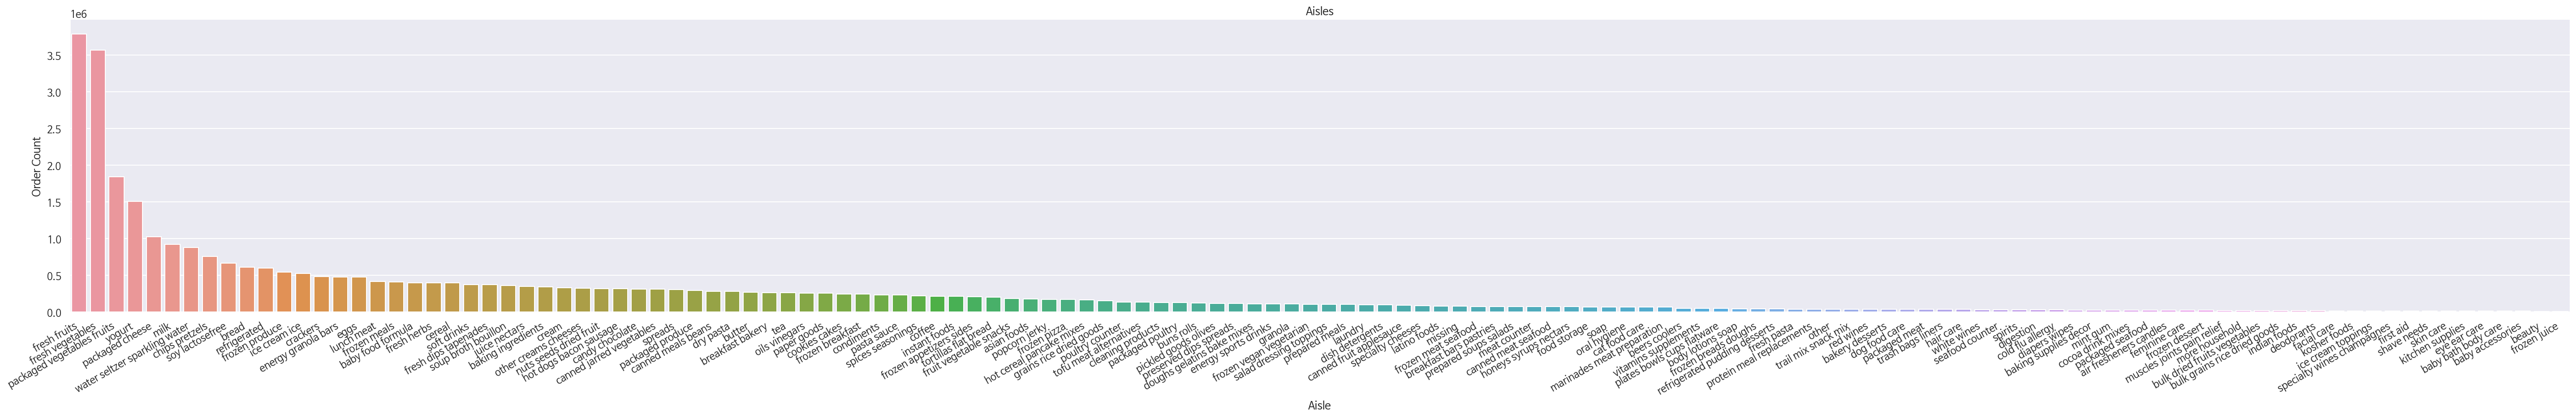

In [30]:
plt.figure(figsize=(50, 6))
ax = sns.barplot(x=aisle_counts["aisle"], y=aisle_counts["order_count"], data=aisle_counts)
plt.title("Aisles")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
# plt.xticks(rotation=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

주문량이 많은 통로 구역이 있고, 주문량이 그저그런 통로 구역이 있고, 주문량이 저조한 통로 구역이 있음

- 제품 위치한 구역의 통로이름 별 주문 수량 top10 / bottom10 시각화

In [31]:
# 데이터프레임에서 상위 10개와 하위 10개 aisle 추출
top_10_aisles = aisle_counts.head(10)
bottom_10_aisles = aisle_counts.tail(10)

In [32]:
top_10_aisles

,aisle,order_count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
5,milk,923659
6,water seltzer sparkling water,878150
7,chips pretzels,753739
8,soy lactosefree,664493
9,bread,608469


In [33]:
bottom_10_aisles

,aisle,order_count
124,specialty wines champagnes,11659
125,first aid,11411
126,shave needs,10876
127,skin care,10698
128,kitchen supplies,9620
129,eye ear care,9522
130,baby bath body care,8909
131,baby accessories,8466
132,beauty,6455
133,frozen juice,5147


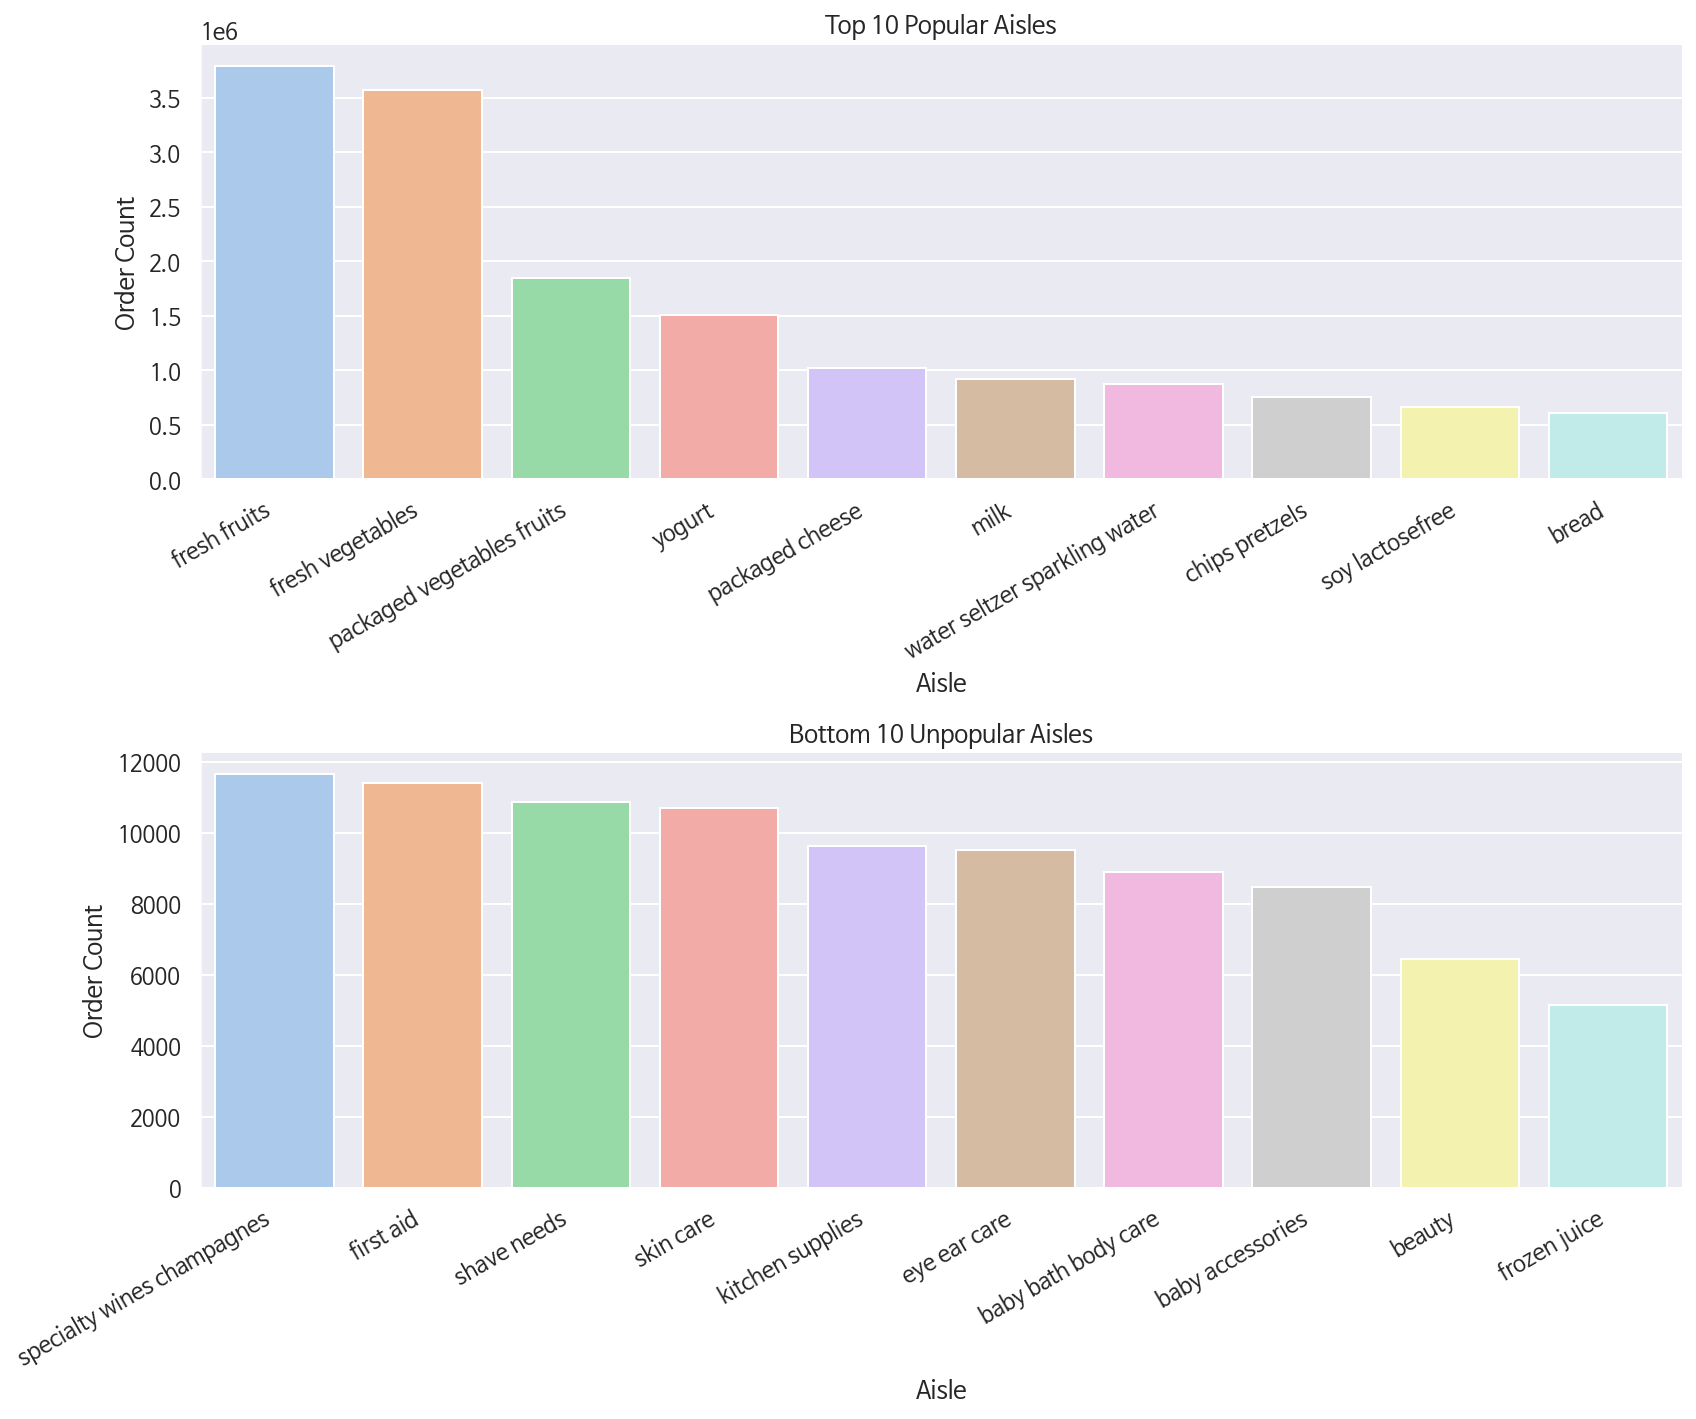

In [34]:
# 시각화 설정
plt.figure(figsize=(12, 10))

# 가장 인기 있는 aisle 시각화
plt.subplot(2, 1, 1)
ax1 = sns.barplot(x=top_10_aisles["aisle"], y=top_10_aisles["order_count"], data=top_10_aisles)
plt.title("Top 10 Popular Aisles")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

# 가장 인기가 없는 aisle 시각화
plt.subplot(2, 1, 2)
ax2 = sns.barplot(x=bottom_10_aisles["aisle"], y=bottom_10_aisles["order_count"], data=bottom_10_aisles)
plt.title("Bottom 10 Unpopular Aisles")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

# 그래프 표시
plt.tight_layout()
plt.show()

### 재방문 간격 분석

4. 마트에 가장 자주 방문해주신 단골 회원을 찾아라! - 상위 100명 뽑기!
- 방문 주기가 짧고 방문횟수가 많은 회원


재방문까지 걸린 일자는 0일에서 30일까지로 분포한다. 0일은 당일에 재방문한 경우이다. 
재방문까지 걸린 일자에 결측치가 많은데, 이 경우는 첫 방문을 의미한다.

In [35]:
df_sorted = df.sort_values(by=['user_id', 'order_number'])
df_sorted.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
3182662,2539329,196,1,0,1,prior,1,2,8,NaN,Soda,77,7,soft drinks,beverages
13944842,2539329,14084,2,0,1,prior,1,2,8,NaN,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
18501477,2539329,26088,4,0,1,prior,1,2,8,NaN,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks


In [157]:
# 재방문 평균 계산
revisit_mean = df_sorted.groupby('user_id')['days_since_prior_order'].mean().reset_index()
revisit_mean.rename(columns={'days_since_prior_order': 'revisit_mean'}, inplace=True)
revisit_mean.head()

,user_id,revisit_mean
0,1,19.203125
1,2,18.015625
2,3,11.484375
3,4,15.359375
4,5,12.312500


In [158]:
# 재방문 횟수 계산
revisit_cnt = df_sorted.groupby(['user_id', 'order_id'])['days_since_prior_order'].nunique().reset_index()
revisit_cnt = revisit_cnt.groupby('user_id')['days_since_prior_order'].sum().reset_index()
revisit_cnt.rename(columns={'days_since_prior_order': 'revisit_count'}, inplace=True)
revisit_cnt.head()

,user_id,revisit_count
0,1,10
1,2,14
2,3,11
3,4,4
4,5,4


In [159]:
revisit_merge = pd.merge(revisit_mean, revisit_cnt, on='user_id')
revisit_merge['revisit_mean'] = revisit_merge['revisit_mean'].astype(int)
revisit_merge.head()

,user_id,revisit_mean,revisit_count
0,1,19,10
1,2,18,14
2,3,11,11
3,4,15,4
4,5,12,4


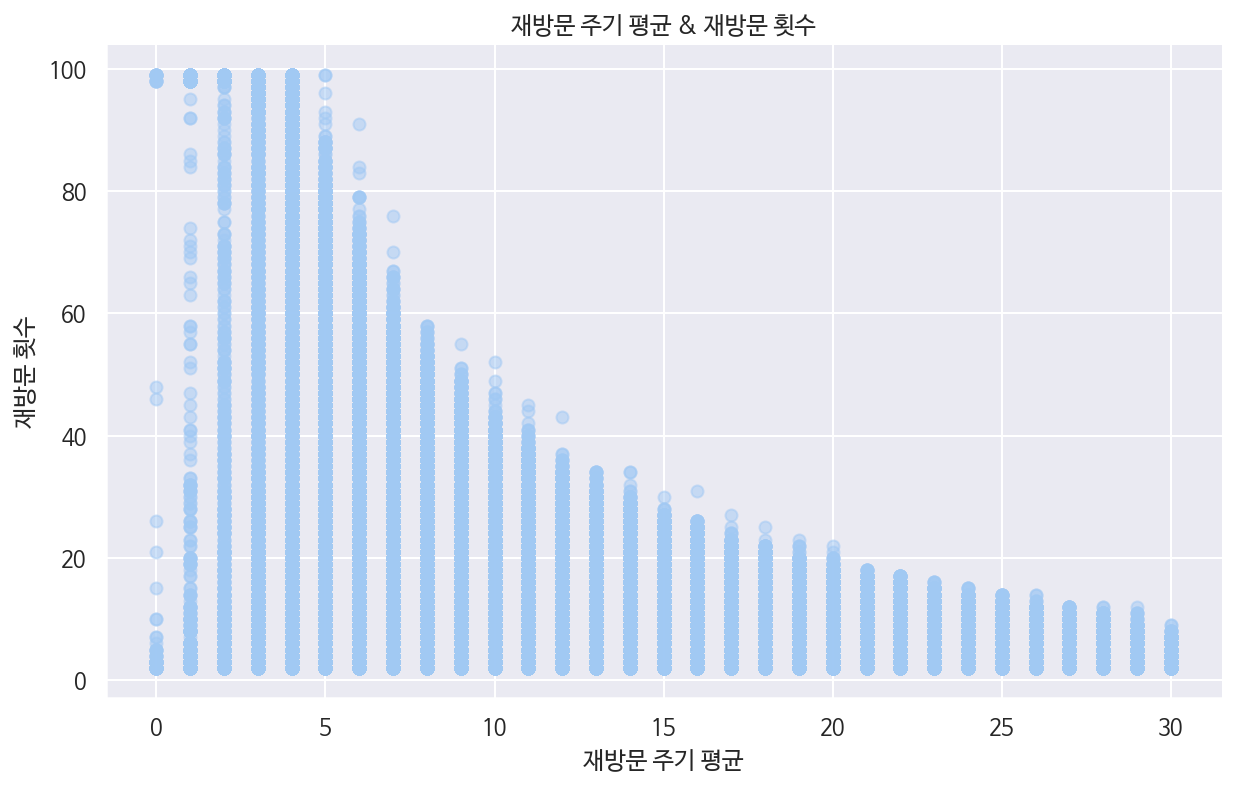

In [160]:
# 산포도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(revisit_merge['revisit_mean'], revisit_merge['revisit_count'], alpha=0.5)

plt.xlabel('재방문 주기 평균')
plt.ylabel('재방문 횟수')
plt.title('재방문 주기 평균 & 재방문 횟수')
plt.grid(True)
plt.show()

In [161]:
top_user = df['user_id'].value_counts()
top_user = top_user[top_user > 1000]
top_user = top_user.reset_index()
top_user.columns = ['user_id', 'purchase_count']
top_user

,user_id,purchase_count
0,201268,3725
1,129928,3689
2,164055,3089
3,176478,2952
4,186704,2936
...,...,...
2181,177189,1001
2182,65807,1001
2183,174301,1001
2184,201774,1001


In [162]:
top_revisit = pd.merge(top_user, revisit_merge, on='user_id', how='inner')
top_revisit

,user_id,purchase_count,revisit_mean,revisit_count
0,201268,3725,3,98
1,129928,3689,5,64
2,164055,3089,3,99
3,176478,2952,2,99
4,186704,2936,3,98
...,...,...,...,...
2181,177189,1001,5,49
2182,65807,1001,3,96
2183,174301,1001,7,60
2184,201774,1001,7,47


데이터 밀도 표현: Hexbin Plot은 데이터의 밀도를 시각적으로 표현하는 데 사용된다. 산점도로 표현하면 데이터 포인트가 겹쳐서 보이거나 밀집된 영역의 밀도를 구별하기 어려울 수 있지만, Hexbin Plot은 이러한 문제를 해결하기 위해 사용된다.

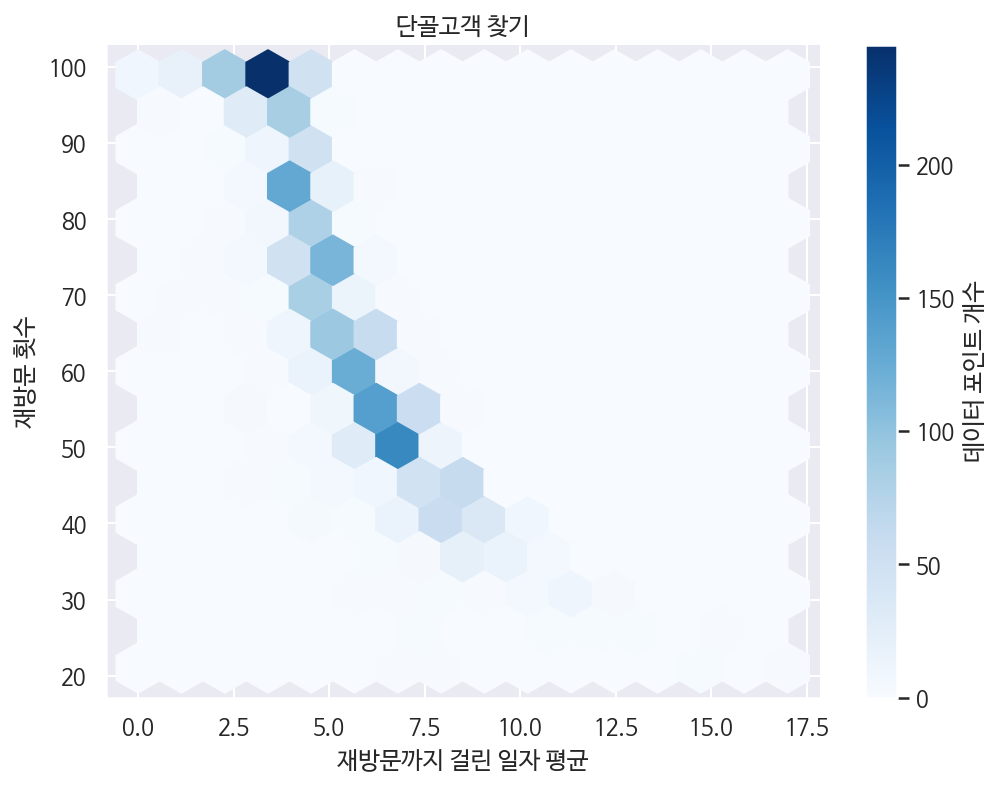

In [163]:
# Hexbin Plot 그리기
plt.figure(figsize=(8, 6))
# x = revisit_merge['revisit_mean']
# y = revisit_merge['revisit_count']
x = top_revisit['revisit_mean']
y = top_revisit['revisit_count']
hb = plt.hexbin(x, y, gridsize=15, cmap='Blues')
plt.xlabel('재방문까지 걸린 일자 평균')
plt.ylabel('재방문 횟수')
plt.title('단골고객 찾기')

# 컬러 바 추가
cb = plt.colorbar(hb, label='데이터 포인트 개수')

# 그래프 표시
plt.show()

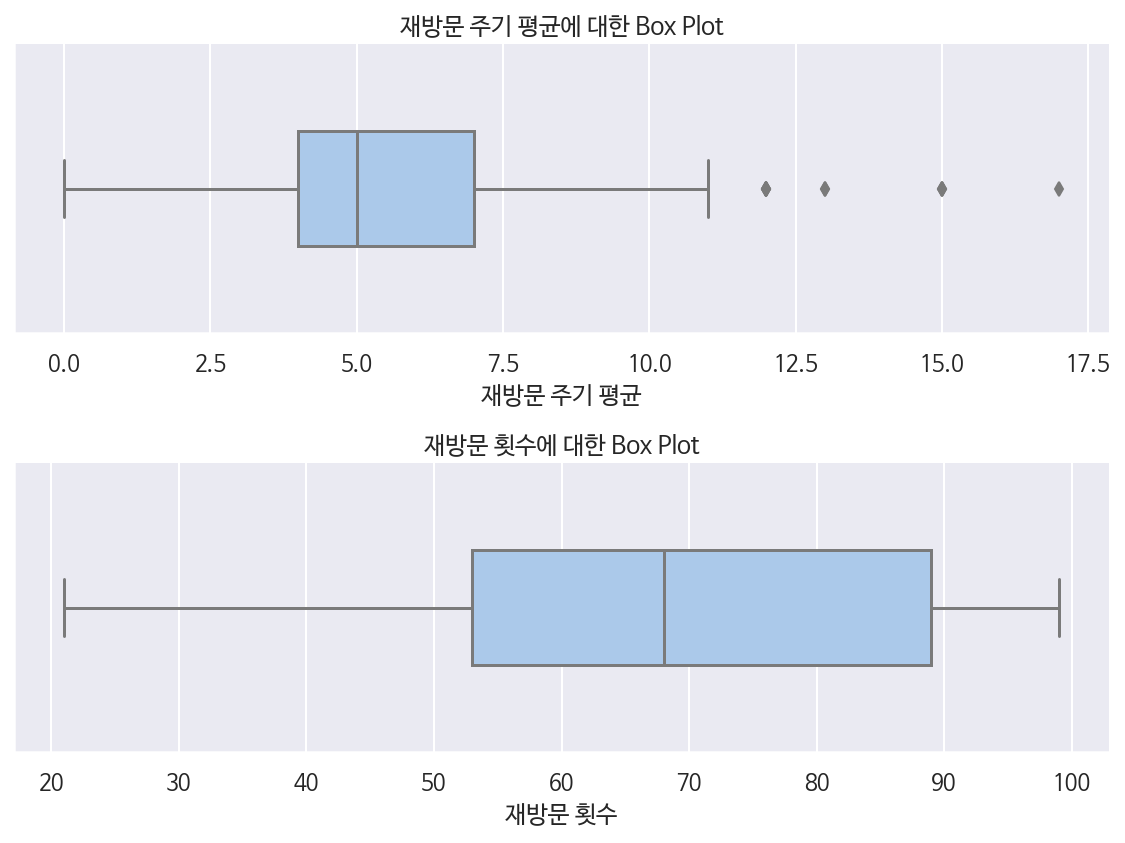

In [164]:
plt.figure(figsize=(8, 6))

# 첫 번째 Box Plot
plt.subplot(2, 1, 1)
sns.boxplot(x='revisit_mean', data=top_revisit, width=0.4)
plt.xlabel('재방문 주기 평균')
plt.title('재방문 주기 평균에 대한 Box Plot')

# 두 번째 Box Plot
plt.subplot(2, 1, 2)
sns.boxplot(x='revisit_count', data=top_revisit, width=0.4)
plt.xlabel('재방문 횟수')
plt.title('재방문 횟수에 대한 Box Plot')

# 그래프 표시
plt.tight_layout()
plt.show()

In [174]:
# revisit_10_under = top_revisit[(top_revisit['revisit_mean'] > 1)&(top_revisit['revisit_mean'] < 10)]
revisit_10_under = top_revisit[top_revisit['revisit_mean'] < 10]
revisit_10_under

,user_id,purchase_count,revisit_mean,revisit_count
0,201268,3725,3,98
1,129928,3689,5,64
2,164055,3089,3,99
3,176478,2952,2,99
4,186704,2936,3,98
...,...,...,...,...
2181,177189,1001,5,49
2182,65807,1001,3,96
2183,174301,1001,7,60
2184,201774,1001,7,47


In [175]:
# # Hexbin Plot 그리기
# plt.figure(figsize=(8, 6))
# x = revisit_10_under['revisit_mean']
# y = revisit_10_under['revisit_count']
# hb = plt.hexbin(x, y, gridsize=15, cmap='Blues')
# plt.xlabel('재방문까지 걸린 일자 평균')
# plt.ylabel('재방문 횟수')
# plt.title('단골고객 찾기')

# # 컬러 바 추가
# cb = plt.colorbar(hb, label='데이터 포인트 개수')

# # 그래프 표시
# plt.show()

재방문까지 걸린 일자 평균과 재방문 횟수를 모두 고려하여 total_score를 생성하여 단골 고객을 찾는다.

In [176]:
# # 가중치 설정 (조절 가능)
# w1 = 1.5  # 재방문까지 걸린 일자 평균의 가중치
# w2 = 1  # 재방문 횟수의 가중치

# # 총합 지표 계산
# revisit_10_under['total_score'] = (revisit_10_under['revisit_mean'] * w1) + (revisit_10_under['revisit_count'] * w2)
# revisit_10_under

w1 = 1.5    # 재방문까지 걸린 일자 평균의 가중치
w2 = 1      # 재방문 횟수의 가중치
w3 = 1.3    # 상품 구매 횟수의 가중치

# 총합 지표 계산
revisit_10_under['total_score'] = (revisit_10_under['revisit_mean'] * w1) + \
                                  (revisit_10_under['revisit_count'] * w2) + \
                                  (revisit_10_under['purchase_count'] * w3)

# 현재 total_score 값 중 최소값과 최대값 계산
min_total_score = revisit_10_under['total_score'].min()
max_total_score = revisit_10_under['total_score'].max()

# 설정 범위 (0~100)로 최소값과 최대값 설정
min_target = 0
max_target = 100

# total_score 값을 0에서 100 사이로 스케일링
revisit_10_under['scaled_total_score'] = ((revisit_10_under['total_score'] - min_total_score) /
                                           (max_total_score - min_total_score)) * (max_target - min_target) + min_target
revisit_10_under['scaled_total_score'] = revisit_10_under['scaled_total_score'].round(1)

revisit_10_under


,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
1,129928,3689,5,64,4867.2,97.8
2,164055,3089,3,99,4119.2,77.0
3,176478,2952,2,99,3939.6,72.0
4,186704,2936,3,98,3919.3,71.5
...,...,...,...,...,...,...
2181,177189,1001,5,49,1357.8,0.2
2182,65807,1001,3,96,1401.8,1.4
2183,174301,1001,7,60,1371.8,0.6
2184,201774,1001,7,47,1358.8,0.2


In [177]:
# 재방문까지 걸린 일자 평균이 가장 큰 값은?
revisit_10_under['revisit_mean'].max()

9

In [178]:
# 재방문 횟수에서 가장 작은 값은?
revisit_10_under['revisit_count'].min()

21

In [179]:
# 재방문 횟수에 대한 boxplot 결과를 참고하여 횟수가 80 이상인 고객으로 필터링
top_customers = revisit_10_under[revisit_10_under['revisit_count'] >= 80]
top_customers

,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
2,164055,3089,3,99,4119.2,77.0
3,176478,2952,2,99,3939.6,72.0
4,186704,2936,3,98,3919.3,71.5
5,137629,2931,3,99,3913.8,71.3
...,...,...,...,...,...,...
2171,89724,1002,2,99,1404.6,1.5
2172,12772,1001,3,99,1404.8,1.5
2173,187972,1001,2,99,1403.3,1.4
2176,186835,1001,3,98,1403.8,1.4


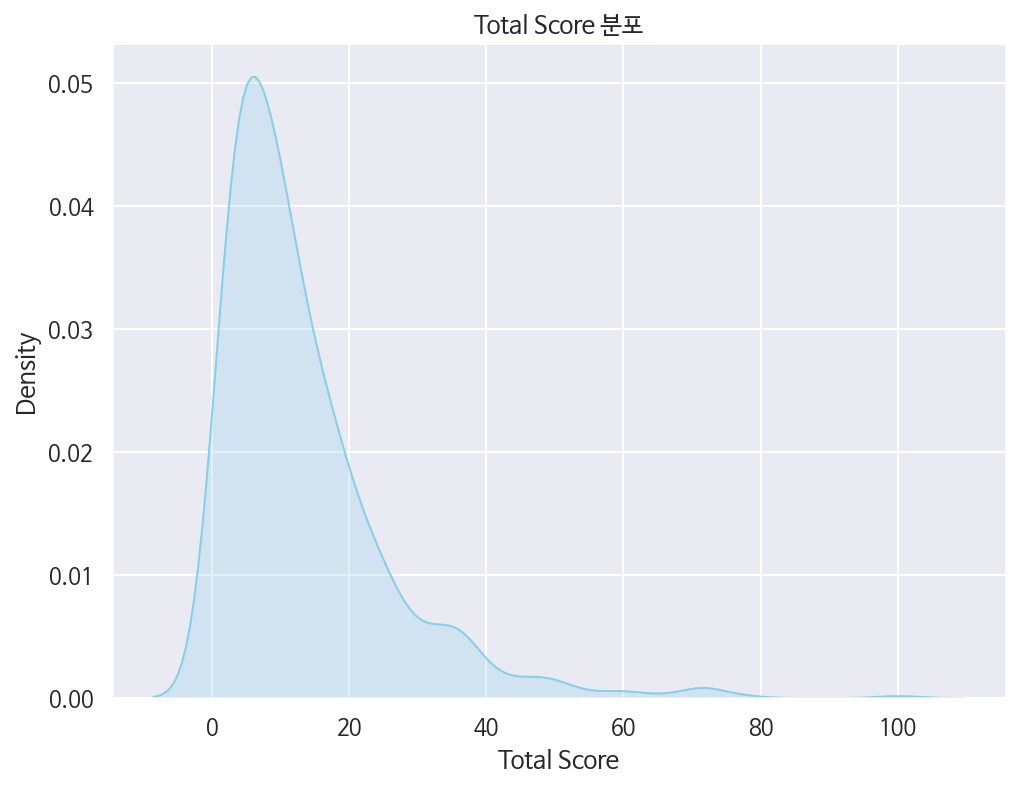

In [180]:
# KDE 그래프 그리기
plt.figure(figsize=(8, 6))
sns.kdeplot(data=top_customers['scaled_total_score'], shade=True, color='skyblue')
plt.xlabel('Total Score')
plt.ylabel('Density')
plt.title('Total Score 분포')

plt.show()

In [182]:
# 단골 고객은?
top_customers[top_customers['scaled_total_score'] >= 30]

,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
2,164055,3089,3,99,4119.2,77.0
3,176478,2952,2,99,3939.6,72.0
4,186704,2936,3,98,3919.3,71.5
5,137629,2931,3,99,3913.8,71.3
...,...,...,...,...,...,...
122,55935,1807,3,98,2451.6,30.6
123,93519,1807,1,98,2448.6,30.5
124,73080,1806,2,98,2448.8,30.5
125,195573,1805,3,94,2445.0,30.4


찐..단골고객..?